In [1]:
import numpy as np
import os
import sys
import copy

import torch
from torch import nn

import importlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anm

sys.path.insert(0, "../src/")
import data
import model
import train

#import nmrglue as ng
import scipy
import scipy.io

import pickle as pk

np.random.seed(321)

In [2]:
mods = ["Ensemble_PIPNet_2022_07_18_inv_prod_1", "Ensemble_PIPNet_2022_07_18_inv_prod_2",
        #"Ensemble_PIPNet_2022_07_18_inv_prod_3", "Ensemble_PIPNet_2022_07_18_inv_prod_4",
        #"Ensemble_PIPNet_2022_07_18_inv_prod_5",
        "Ensemble_PIPNet_2022_07_18_inv_prod_6",
        "Ensemble_PIPNet_2022_07_18_inv_prod_7", "Ensemble_PIPNet_2022_07_18_inv_prod_8",
        "Ensemble_PIPNet_2022_07_18_inv_prod_9", "Ensemble_PIPNet_2022_07_18_inv_prod_10",
        "Ensemble_PIPNet_2022_07_18_inv_prod_11", "Ensemble_PIPNet_2022_07_18_inv_prod_12",
        "Ensemble_PIPNet_2022_07_18_inv_prod_13", "Ensemble_PIPNet_2022_07_18_inv_prod_14",
        "Ensemble_PIPNet_2022_07_18_inv_prod_15", "Ensemble_PIPNet_2022_07_18_inv_prod_16"]

fig_dir = "../figures/production_training_inv/"

n_avg = 50
n_chk = 200

#chks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
chks = [10, 50, 100, 150, 200]

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [3]:
all_mod_losses = []
all_mod_val_losses = []

avg_losses = []
min_losses = []
avg_val_losses = []
min_val_losses = []

avg_loss_components = []
min_loss_components = []
avg_val_loss_components = []
min_val_loss_components = []

best_inds = []

for imod, mod in enumerate(mods):
    in_dir = f"../data/{mod}/"
    
    if not os.path.exists(in_dir):
        raise ValueError(f"Unknown model: {mod}")
    
    # Load loss and learning rate
    all_lrs = np.load(in_dir + "all_lrs.npy")
    all_losses = np.load(in_dir + "all_losses.npy")
    all_val_losses = np.load(in_dir + "all_val_losses.npy")
    
    all_mod_losses.append(all_losses)
    all_mod_val_losses.append(all_val_losses)

    try:
        all_loss_components = np.load(in_dir + "all_loss_components.npy")
        all_val_loss_components = np.load(in_dir + "all_val_loss_components.npy")
        mean_loss_components = np.mean(all_loss_components, axis=1)
        mean_val_loss_components = np.mean(all_val_loss_components, axis=1)
    except:
        all_loss_components = None
        all_val_loss_components = None
        mean_loss_components = None
        mean_val_loss_components = None

    mean_losses = np.mean(all_losses, axis=1)
    mean_val_losses = np.mean(all_val_losses, axis=1)
    
    avg_losses.append(np.mean(mean_losses[-n_avg:]))
    min_losses.append(np.min(mean_losses))
    
    avg_val_losses.append(np.mean(mean_val_losses[-n_avg:]))
    min_val_losses.append(np.min(mean_val_losses))
    
    best_inds.append(np.argmin(mean_val_losses))
    
    avg_loss_components.append(np.mean(mean_loss_components[-n_avg:], axis=0))
    min_loss_components.append(np.min(mean_loss_components, axis=0))
    avg_val_loss_components.append(np.mean(mean_val_loss_components[-n_avg:], axis=0))
    min_val_loss_components.append(np.min(mean_val_loss_components, axis=0))
    
    # Plot training results
    d = 0.5
    max_diff = 0.5

    jumps = [50]

    if len(jumps) > 0:

        fig = plt.figure(figsize=(4,3))

        axs = []
        for i in range(len(jumps) + 1):
            axs.append(fig.add_subplot(len(jumps)+1, 1,i+1))

            # Plot broken axes markers
            if i > 0:
                axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                            markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

                axs[i].spines["top"].set_visible(False)

            if i < len(jumps):
                axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                            markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

                axs[i].spines["bottom"].set_visible(False)
                axs[i].set_xticks([])

            h1 = axs[i].plot(range(1, n_chk+1), mean_losses)
            h2 = axs[i].plot(range(1, n_chk+1), mean_val_losses)
            axs[i].set_xlim(1, n_chk)

            if i == 0:
                M = np.max(mean_losses[:jumps[i]])
                M = max(M, np.max(mean_val_losses[:jumps[i]]))
                m = np.min(mean_losses[:jumps[i]])
                m = min(M, np.min(mean_val_losses[:jumps[i]]))

            elif i == len(jumps):
                M = np.max(mean_losses[jumps[i-1]:])
                M = max(M, np.max(mean_val_losses[jumps[i-1]:]))
                m = np.min(mean_losses[jumps[i-1]:])
                m = min(m, np.min(mean_val_losses[jumps[i-1]:]))

            else:
                M = np.max(mean_losses[jumps[i-1]:jumps[i]])
                M = max(M, np.max(mean_val_losses[jumps[i-1]:jumps[i]]))
                m = np.min(mean_losses[jumps[i-1]:jumps[i]])
                m = min(m, np.min(mean_val_losses[jumps[i-1]:jumps[i]]))

            r = M - m

            axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)

        axs[0].legend([h1[0], h2[0]], ["Training", "Validation"])

        fig.tight_layout()

        plt.savefig(fig_dir + f"mod_{mod.split('_')[-1]}_loss_split.pdf")

#        plt.show()
        plt.close()
        
        d = 0.1
        max_diff = 0.5

        if mean_loss_components is not None:

            for k in range(mean_loss_components.shape[-1]):

                pp = f"Loss component {k}:\n"

                pp += "Training loss minimum: {:.3e}, mean over 10 last epochs: {:.3e}\n".format(np.min(mean_loss_components[:, k]), np.mean(mean_loss_components[-10:, k]))
                pp += "Validation loss minimum: {:.3e}, mean over 10 last epochs: {:.3e}\n".format(np.min(mean_val_loss_components[:, k]), np.mean(mean_val_loss_components[-10:, k]))

                with open(f"{fig_dir}mod_{mod.split('_')[-1]}_loss_component_{k}_summary.txt", "w") as F:
                    F.write(pp)

                jumps = [50]

                if len(jumps) > 0:

                    fig = plt.figure(figsize=(4,3))

                    axs = []
                    for i in range(len(jumps) + 1):
                        axs.append(fig.add_subplot(len(jumps)+1, 1,i+1))

                        # Plot broken axes markers
                        if i > 0:
                            axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

                            axs[i].spines["top"].set_visible(False)

                        if i < len(jumps):
                            axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

                            axs[i].spines["bottom"].set_visible(False)
                            axs[i].set_xticks([])

                        h1 = axs[i].plot(range(1, n_chk+1), mean_loss_components[:, k])
                        h2 = axs[i].plot(range(1, n_chk+1), mean_val_loss_components[:, k])
                        axs[i].set_xlim(1, n_chk)

                        if i == 0:
                            M = np.max(mean_loss_components[:jumps[i], k])
                            M = max(M, np.max(mean_val_loss_components[:jumps[i], k]))
                            m = np.min(mean_loss_components[:jumps[i], k])
                            m = min(M, np.min(mean_val_loss_components[:jumps[i], k]))

                        elif i == len(jumps):
                            M = np.max(mean_loss_components[jumps[i-1]:, k])
                            M = max(M, np.max(mean_val_loss_components[jumps[i-1]:, k]))
                            m = np.min(mean_loss_components[jumps[i-1]:, k])
                            m = min(m, np.min(mean_val_loss_components[jumps[i-1]:, k]))

                        else:
                            M = np.max(mean_loss_components[jumps[i-1]:jumps[i], k])
                            M = max(M, np.max(mean_val_loss_components[jumps[i-1]:jumps[i], k]))
                            m = np.min(mean_loss_components[jumps[i-1]:jumps[i], k])
                            m = min(m, np.min(mean_val_loss_components[jumps[i-1]:jumps[i], k]))

                        r = M - m

                        axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)

                    axs[0].legend([h1[0], h2[0]], ["Training", "Validation"])

                    fig.tight_layout()

                    plt.savefig(fig_dir + f"mod_{mod.split('_')[-1]}_loss_component_{k}_split.pdf")

#                    plt.show()
                    plt.close()
    

avg_loss_components = np.array(avg_loss_components)
min_loss_components = np.array(min_loss_components)
avg_val_loss_components = np.array(avg_val_loss_components)
min_val_loss_components = np.array(min_val_loss_components)

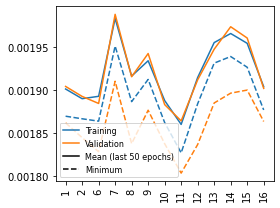

In [4]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(avg_losses, "C0")
ax.plot(min_losses, "--C0")
ax.plot(avg_val_losses, "C1")
ax.plot(min_val_losses, "--C1")

hs = []
legs = ["Training", "Validation", f"Mean (last {n_avg} epochs)", "Minimum"]

hs.append(mpl.lines.Line2D([0], [0], color="C0"))
hs.append(mpl.lines.Line2D([0], [0], color="C1"))
hs.append(mpl.lines.Line2D([0], [0], color="k"))
hs.append(mpl.lines.Line2D([0], [0], color="k", linestyle="--"))

ax.set_xticks(range(len(avg_losses)))
ax.set_xticklabels([mod.split("_")[-1] for mod in mods], rotation=90)

ax.legend(hs, legs, fontsize=8)

fig.tight_layout()
plt.savefig(f"{fig_dir}losses.pdf")

plt.show()
plt.close()

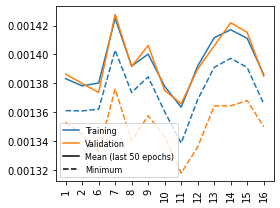

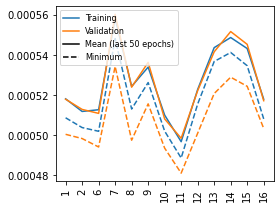

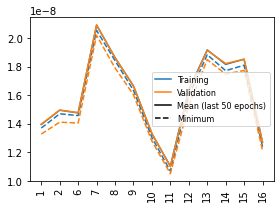

In [5]:
for i in range(avg_loss_components.shape[1]):

    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)

    ax.plot(avg_loss_components[:, i], "C0")
    ax.plot(min_loss_components[:, i], "--C0")
    ax.plot(avg_val_loss_components[:, i], "C1")
    ax.plot(min_val_loss_components[:, i], "--C1")

    hs = []
    legs = ["Training", "Validation", f"Mean (last {n_avg} epochs)", "Minimum"]

    hs.append(mpl.lines.Line2D([0], [0], color="C0"))
    hs.append(mpl.lines.Line2D([0], [0], color="C1"))
    hs.append(mpl.lines.Line2D([0], [0], color="k"))
    hs.append(mpl.lines.Line2D([0], [0], color="k", linestyle="--"))

    ax.set_xticks(range(len(avg_losses)))
    ax.set_xticklabels([mod.split("_")[-1] for mod in mods], rotation=90)
    
    ax.legend(hs, legs, fontsize=8)

    fig.tight_layout()
    plt.savefig(f"{fig_dir}loss_component_{i}.pdf")

    plt.show()
    plt.close()

In [6]:
trn_losses = np.concatenate(all_mod_losses, axis=1)
val_losses = np.concatenate(all_mod_val_losses, axis=1)

In [7]:
avg_trn_losses = np.mean(trn_losses, axis=1)
std_trn_losses = np.std(trn_losses, axis=1)

avg_val_losses = np.mean(val_losses, axis=1)
std_val_losses = np.std(val_losses, axis=1)

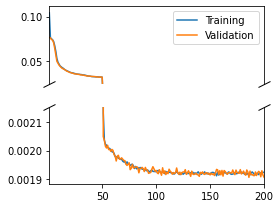

In [8]:
n_chk = trn_losses.shape[0]
d = 0.5
max_diff = 0.5

jumps = [50]

if len(jumps) > 0:

    fig = plt.figure(figsize=(4,3))

    axs = []
    for i in range(len(jumps) + 1):
        axs.append(fig.add_subplot(len(jumps)+1, 1,i+1))

        # Plot broken axes markers
        if i > 0:
            axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

            axs[i].spines["top"].set_visible(False)

        if i < len(jumps):
            axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

            axs[i].spines["bottom"].set_visible(False)
            axs[i].set_xticks([])

        h1 = axs[i].plot(range(1, n_chk+1), avg_trn_losses)
        h2 = axs[i].plot(range(1, n_chk+1), avg_val_losses)
        axs[i].set_xlim(1, n_chk)

        if i == 0:
            M = np.max(avg_trn_losses[:jumps[i]])
            M = max(M, np.max(avg_val_losses[:jumps[i]]))
            m = np.min(avg_trn_losses[:jumps[i]])
            m = min(M, np.min(avg_val_losses[:jumps[i]]))

        elif i == len(jumps):
            M = np.max(avg_trn_losses[jumps[i-1]:])
            M = max(M, np.max(avg_val_losses[jumps[i-1]:]))
            m = np.min(avg_trn_losses[jumps[i-1]:])
            m = min(m, np.min(avg_val_losses[jumps[i-1]:]))

        else:
            M = np.max(avg_trn_losses[jumps[i-1]:jumps[i]])
            M = max(M, np.max(mean_val_losses[jumps[i-1]:jumps[i]]))
            m = np.min(avg_trn_losses[jumps[i-1]:jumps[i]])
            m = min(m, np.min(avg_val_losses[jumps[i-1]:jumps[i]]))

        r = M - m

        axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)

    axs[0].legend([h1[0], h2[0]], ["Training", "Validation"])

    fig.tight_layout()

    plt.savefig(fig_dir + f"all_models_loss_split.pdf")

    plt.show()
    plt.close()

In [9]:
def clean_split(l, delimiter):
    """
    Split a line with the desired delimiter, ignoring delimiters present in arrays or strings
    
    Inputs: - l     Input line
    
    Output: - ls    List of sub-strings making up the line
    """
    
    # Initialize sub-strings
    ls = []
    clean_l = ""
    
    # Loop over all line characters
    in_dq = False
    in_sq = False
    arr_depth = 0
    for li in l:
        # Identify strings with double quotes
        if li == "\"":
            if not in_dq:
                in_dq = True
            else:
                in_dq = False
        
        # Identify strings with single quotes
        if li == "\'":
            if not in_sq:
                in_sq = True
            else:
                in_sq = False
        
        # Identify arrays
        if li == "[":
            if not in_sq and not in_dq:
                arr_depth += 1
        if li == "]":
            if not in_sq and not in_dq:
                arr_depth -= 1
        
        # If the delimiter is not within quotes or in an array, split the line at that character
        if li == delimiter and not in_dq and not in_sq and arr_depth == 0:
            ls.append(clean_l)
            clean_l = ""
        else:
            clean_l += li
    
    ls.append(clean_l)
        
    return ls

In [10]:
def get_array(l):
    """
    Get the values in an array contained in a line
    
    Input:  - l         Input line
    
    Output: - vals      Array of values
    """
    
    # Identify empty array
    if l.strip() == "[]":
        return []
    
    # Initialize array
    vals = []
    clean_l = ""
    
    # Loop over all line characters
    arr_depth = 0
    for li in l:
    
        # Identify end of array
        if li == "]":
            arr_depth -= 1
            
            # Check that there are not too many closing brackets for the opening ones
            if arr_depth < 0:
                raise ValueError("Missing \"[\" for matching the number of \"]\"")
        
        # If we are within the array, extract the character
        if arr_depth > 0:
            clean_l += li
    
        # Identify start of array
        if li == "[":
            arr_depth += 1
    
    # Check that the array is properly closed at the end
    if arr_depth > 0:
        raise ValueError("Missing \"]\" for matching the number of \"[\"")
    
    # Extract elements in the array
    ls = clean_split(clean_l, ",")
    
    # Get the value of each element in the array
    for li in ls:
        vals.append(get_val(li.strip()))

    return vals

In [11]:
def get_val(val):
    
    # Remove tailing comma
    if val.endswith(","):
        val = val[:-1]
    
    # Float / Int
    if val.isnumeric():
        
        if "." in val:
            return float(val)
        else:
            return int(val)
    
    # Bool
    if val.lower() == "true":
        return True
    if val.lower() == "false":
        return False
    
    # String
    if val.startswith("\""):
        return val.split("\"")[1]
    
    # List
    if val.startswith("["):
        
        return get_array(val)
    
    # Try to return a float anyway
    return float(val)

In [12]:
def get_model_pars(mod):
    
    # Get model architecture
    with open(mod + ".py", "r") as F:
        lines = F.read().split("\n")

    model_pars = {}
    in_pars = False

    # Parse script
    for l in lines:

        # Identify model parameter block start
        if "model_pars = " in l:
            in_pars = True
            continue

        # Identify model parameter block end
        if l.strip() == ")":
            in_pars = False

        if in_pars:
            
            if len(l.strip()) > 0:

                # Get line
                if "(" in l:
                    L = l.split("(")[1].split("#")[0]
                else:
                    L = l.strip().split("#")[0]

                key, val = L.split("=")

                v = get_val(val.strip())

                model_pars[key.strip()] = v

    model_pars["noise"] = 0.
    
    return model_pars

In [13]:
def get_dataset(mod, to_change={}):
    # Get data parameters
    with open(mod + ".py", "r") as F:
        lines = F.read().split("\n")

    data_pars = {}
    in_pars = False

    # Parse script
    for l in lines:

        # Identify model parameter block start
        if "data_pars = " in l:
            in_pars = True

        # Identify model parameter block end
        if l.strip() == ")":
            in_pars = False

        if in_pars:
            # Get line
            if "(" in l:
                L = l.split("(")[1].split("#")[0]
            else:
                L = l.strip().split("#")[0]

            if "=" in L:

                key, val = L.split("=")

                v = get_val(val.strip())

                data_pars[key.strip()] = v
    
    for k in to_change:
        data_pars[k] = to_change[k]

    dataset = data.PIPDatasetGLS(**data_pars)
    
    return data_pars, dataset

In [14]:
def plot_checkpoint(X, y_trg, y_pred, y_std, ys=None, input_factor=0.5, show=True, save=None, anim=False, all_steps=False,
                    c_start=[0., 1., 1.], c_stop=[0., -1., 0.], c2_start=[1., 1., 0.], c2_stop=[0., -1., 0.]):
    
    if y_std is None:
        y_std = [[] for _ in range(X.shape[0])]
    
    n_pts = X.shape[-1]
    
    n = X.shape[1] - 1
    
    colors = [[c0 + (i / n) * c1 for c0, c1 in zip(c_start, c_stop)] for i in range(n+1)]
    
    if ys is not None:
        n2 = ys.shape[0] - 1
        colors2 = [[c0 + (i / n2) * c1 for c0, c1 in zip(c2_start, c2_stop)] for i in range(n2+1)]
    
    for i, (Xi, yi_trg, yi_pred, yi_std) in enumerate(zip(X, y_trg, y_pred, y_std)):
        
        for k in range(yi_pred.shape[0]):
            
            if all_steps or k == yi_pred.shape[0] - 1:

                # Print target vs. pred
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)

                ax.plot(yi_trg[0], linewidth=1.)
                ax.plot(yi_pred[k], linewidth=1.)

                if len(yi_std) > 0:
                    ax.fill_between(range(n_pts), yi_pred[k] - yi_std[k], yi_pred[k] + yi_std[k], facecolor="C1", alpha=0.3)

                ax.legend(["Ground-truth", "Prediction"])

                fig.tight_layout()
                
                if show:
                    plt.show()

                if save is not None:
                    plt.savefig(save + f"sample_{i+1}_pred_step_{k+1}.pdf")

                plt.close()
        
        if anim:
            
            fig = plt.figure(figsize=(4,3))
            ax = fig.add_subplot(1,1,1)
            trg, = ax.plot(range(n_pts), yi_trg[0], lw=1.)
            pred, = ax.plot(range(n_pts), yi_pred[0], lw=1.)
            ax.fill_between(range(n_pts), yi_pred[0] - yi_std[0], yi_pred[0] + yi_std[0], facecolor="C1", alpha=0.3)

            ax.legend(["Ground-truth", f"Prediction {1:02}"])
            
            fig.tight_layout()

            def init():
                ax.set_ylim(-0.1, 1.)
                ax.set_xlim(-1, n_pts)
                return fig,
            
            def update(k):
                ax.collections.clear()
                pred.set_data(range(n_pts), yi_pred[k])
                ax.fill_between(range(n_pts), yi_pred[k] - yi_std[k], yi_pred[k] + yi_std[k], facecolor="C1", alpha=0.3)
                ax.legend(["Ground-truth", f"Prediction {k+1:02}"])
                return fig,
            
            A = anm.FuncAnimation(fig, update, init_func=init, frames=yi_pred.shape[0], interval=250, blit=True)
            
            if save is not None:
                A.save(save + f"sample_{i+1}_pred_anim.gif", dpi=300)
            
            plt.close()
        
        if ys is not None:
            
            for k in range(ys.shape[2]):
                # Print target vs. all preds
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)

                h1 = ax.plot(yi_trg[0], linewidth=1.)

                for c, yi in zip(colors2, ys[:, i, k, :]):
                    ax.plot(yi, linewidth=1., color=c)

                h2 = ax.plot(yi_pred[k], linewidth=1., color="k")

                ax.legend([h1[0], h2[0]], ["Ground-truth", "Prediction"], loc=0)

                fig.tight_layout()
                
                if show:
                    plt.show()

                if save is not None:
                    plt.savefig(save + f"sample_{i+1}_all_preds_step_{k+1}.pdf")

                plt.close()
            
            for j in range(ys.shape[0]):
                
                for k in range(ys.shape[2]):

                    # Print target vs. all preds
                    fig = plt.figure(figsize=(4,3))
                    ax = fig.add_subplot(1,1,1)

                    h1 = ax.plot(yi_trg[0], linewidth=1.)

                    ax.plot(ys[j, i, k, :], linewidth=1., color=colors2[j])

                    h2 = ax.plot(yi_pred[k], linewidth=1., color="k")

                    ax.legend([h1[0], h2[0]], ["Ground-truth", "Prediction"])

                    fig.tight_layout()
                    
                    if show:
                        plt.show()

                    if save is not None:
                        plt.savefig(save + f"sample_{i+1}_pred_step_{k+1}_model_{j+1}.pdf")

                    plt.close()
        
        # Print input and target
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        for x, c in zip(Xi[:, 0, :], colors):
            ax.plot(x / np.max(Xi[:, 0, :]), linewidth=1., color=c)
        ax.plot(yi_trg[0] / np.max(yi_trg[0]) * input_factor, "r", linewidth=1.)
        
        fig.tight_layout()
        
        if show:
            plt.show()
            
        if save is not None:
            plt.savefig(save + f"sample_{i+1}_input.pdf")
            
        plt.close()
    
    return

In [15]:
np.random.seed(2790106421)

In [16]:
import time

In [17]:
data_pars, dataset = get_dataset(mods[0], to_change={"random_mas": False, "nw": 22, "nmin": 8, "nmax": 8, "iso_p": [0.7, 0.3]})

n_samples = 4

X = []
Xs = []
y = []

for i in range(n_samples):
    Xi, Xsi, yi = dataset.__getitem__(0)
    X.append(Xi.unsqueeze(0))
    Xs.append(Xsi.unsqueeze(0))
    y.append(yi.unsqueeze(0))

X = torch.cat(X, dim=0)
Xs = torch.cat(Xs, dim=0)
y = torch.cat(y, dim=0)

In [18]:
for chk in chks:
    
    print(f"Checkpoint {chk}...")
    
    nets = []
    for mod in mods:
        in_dir = f"../data/{mod}/"
        model_pars = get_model_pars(mod)

        net = model.ConvLSTMEnsemble(**model_pars)
        net.eval()

        net.load_state_dict(torch.load(in_dir + f"checkpoint_{chk}_network", map_location=torch.device("cpu")))

        nets.append(net)
    
    model_pars["n_models"] = len(mods)

    agg_net = model.ConvLSTMEnsemble(**model_pars)

    for inet, net in enumerate(nets):
        agg_net.models[inet].load_state_dict(nets[inet].models[0].state_dict())

    agg_net.eval()
    
    with torch.no_grad():
        y_pred, y_errs, ys = agg_net(X)
    
    fdir = fig_dir + f"checkpoint_{chk}/"
    if not os.path.exists(fdir):
        os.mkdir(fdir)
    
    plot_checkpoint(X.numpy(), y.numpy(), y_pred, y_errs, show=False, save=fdir)

Checkpoint 10...
Checkpoint 50...
Checkpoint 100...
Checkpoint 150...
Checkpoint 200...


In [19]:
fdir = fig_dir + "checkpoint_sparse/"

if not os.path.exists(fdir):
    os.mkdir(fdir)

with torch.no_grad():
    y_pred, y_err, ys = agg_net(X[:, ::3])

plot_checkpoint(X[:, ::3].numpy(), y.numpy(), y_pred, y_errs, show=False, save=fdir, all_steps=True)

In [20]:
nets = []
for mod in mods:
    print(mod)
    in_dir = f"../data/{mod}/"
    model_pars = get_model_pars(mod)
    
    net = model.ConvLSTMEnsemble(**model_pars)
    net.eval()
    
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{200}_network", map_location=torch.device("cpu")))
    
    nets.append(net)

Ensemble_PIPNet_2022_07_18_inv_prod_1
Ensemble_PIPNet_2022_07_18_inv_prod_2
Ensemble_PIPNet_2022_07_18_inv_prod_6
Ensemble_PIPNet_2022_07_18_inv_prod_7
Ensemble_PIPNet_2022_07_18_inv_prod_8
Ensemble_PIPNet_2022_07_18_inv_prod_9
Ensemble_PIPNet_2022_07_18_inv_prod_10
Ensemble_PIPNet_2022_07_18_inv_prod_11
Ensemble_PIPNet_2022_07_18_inv_prod_12
Ensemble_PIPNet_2022_07_18_inv_prod_13
Ensemble_PIPNet_2022_07_18_inv_prod_14
Ensemble_PIPNet_2022_07_18_inv_prod_15
Ensemble_PIPNet_2022_07_18_inv_prod_16


In [21]:
model_pars["n_models"] = len(mods)

agg_net = model.ConvLSTMEnsemble(**model_pars)

for inet, net in enumerate(nets):
    agg_net.models[inet].load_state_dict(nets[inet].models[0].state_dict())
    
agg_net.eval()

print("Aggregate model constructed!")

Aggregate model constructed!


In [24]:
out_dir = "../data/final_model_inv/"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [25]:
with open(out_dir + "PIPNet_model_pars.pk", "wb") as F:
    pk.dump([model_pars, data_pars], F)

torch.save(agg_net.state_dict(), out_dir + "PIPNet_model.weights")